# Clustering Analysis with K-Means

# Required libraries

In [1]:
# Required libraries
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pymysql
pymysql.install_as_MySQLdb()


 # Load and preprocess data

In [2]:
# Add project path
sys.path.append(os.path.abspath(".."))

# Import database connection module
from database.db_connection import DatabaseConnector

# Handle database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit on connection failure

# Load data from the database
try:
    data = pd.read_sql("SELECT relative_humidity_2m, wind_speed_10m, temperature_2m FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data from the database: {e}")
    sys.exit(1)  # Exit on data loading failure

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

 # K-Means Clustering

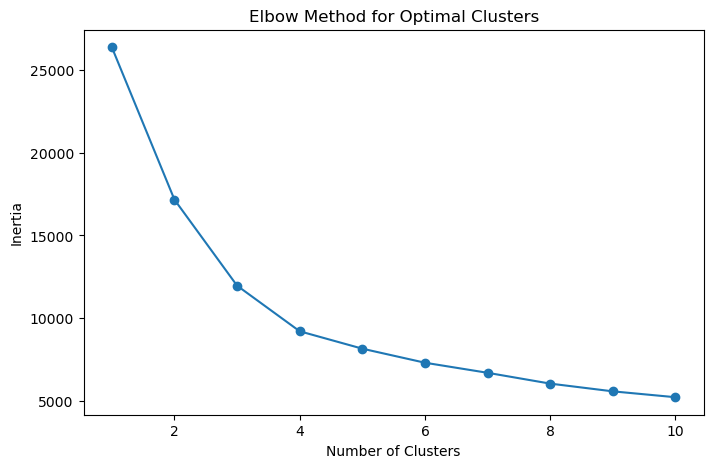

Silhouette Score for 3 clusters: 0.39


In [3]:
# Determine the optimal number of clusters using the elbow method
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Fit the K-Means model
optimal_clusters = 3  # Adjust this based on the elbow curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Calculate silhouette score
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])
print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg:.2f}")

# Interpretation

Elbow Point: 

The "elbow" of the curve, where the rate of decrease in WCSS slows down significantly, suggests the optimal number of clusters. In this graph, the elbow is around 3 clusters, which is why k=3 was chosen for the clustering.

A score of 0.39 indicates that the clusters are moderately well-separated.

Interpretation:

There is some structure in the data that the clusters capture.
However, there is significant overlap between the clusters, meaning some data points are not clearly assigned to one cluster.
This is expected in weather data, as conditions often transition smoothly (e.g., moderately humid and warm conditions may overlap with dry or highly humid conditions).

A score of 0.39 suggests that the data has some clustering tendencies, but the cluster boundaries are not sharply defined.
This is likely due to the natural variability and transitions in weather conditions. For example, days with "moderate humidity and wind" could fall into both Cluster 0 (windy) and Cluster 1 (humid).
Implications for Analysis:
The clustering is not perfect but captures general patterns in the weather data.
For comparing forecasted and actual weather data, this score indicates there may be overlapping clusters, making some predictions less clear

# Visualization of Clusters

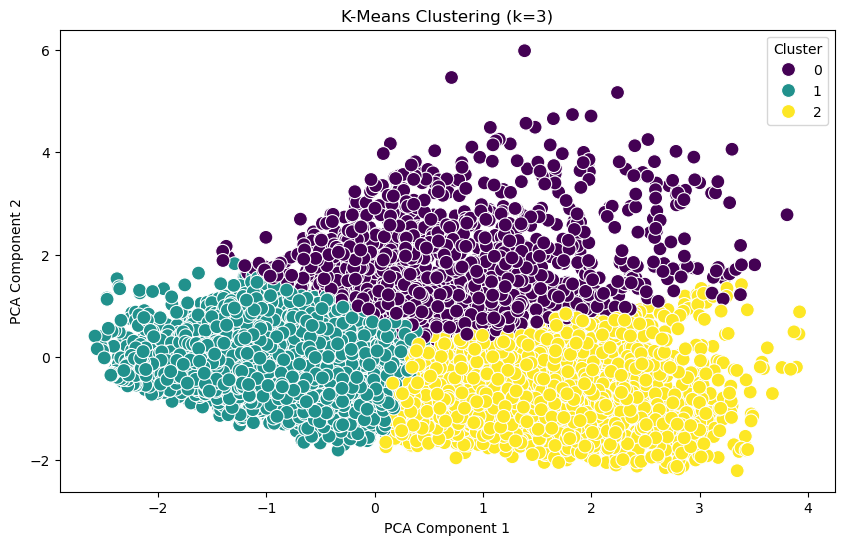

In [4]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data['PCA1'] = data_pca[:, 0]
data['PCA2'] = data_pca[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis', s=100)
plt.title(f"K-Means Clustering (k={optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

 # Cluster Analysis

Cluster Centers:
   relative_humidity_2m  wind_speed_10m  temperature_2m
0             76.761940       14.769140        9.323659
1             91.073495        4.529300        7.867045
2             66.896402        5.319419       19.572735


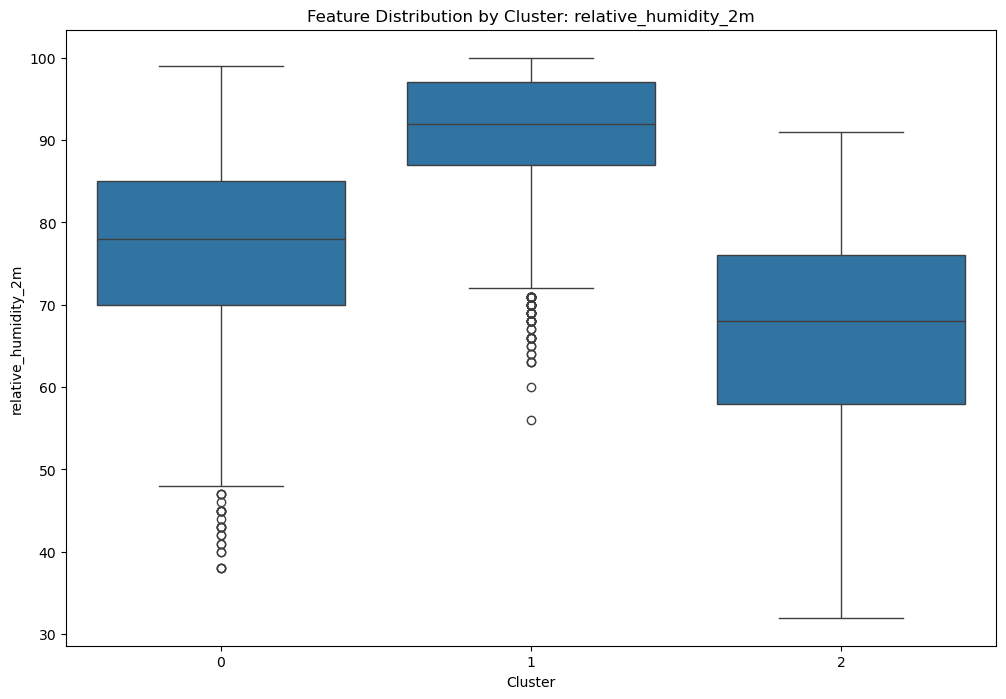

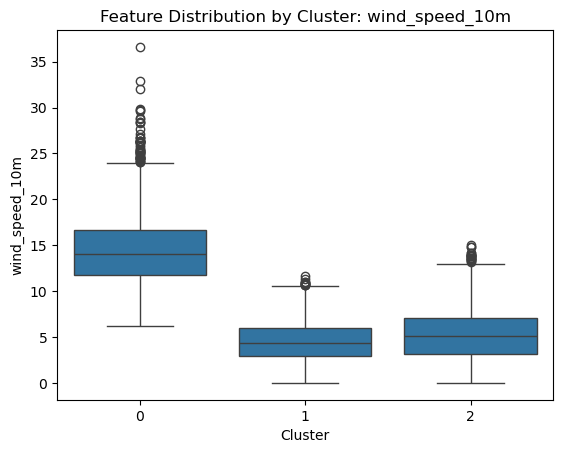

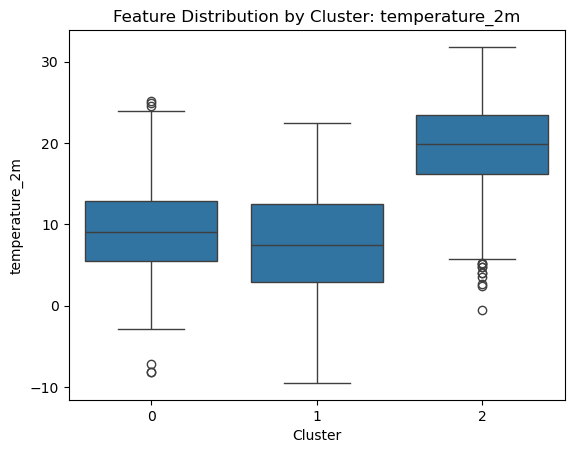

In [5]:
# Analyze the cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=data.columns[:-3])  # Adjust as needed
print("Cluster Centers:")
print(cluster_centers_df)

# Boxplot of features by cluster
plt.figure(figsize=(12, 8))
for feature in data.columns[:-3]:
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(f"Feature Distribution by Cluster: {feature}")
    plt.show()

# Interpretation

relative_humidity_2m:

Cluster 1 (Cool and humid) shows the highest values for relative humidity, with a median close to 90%.
Cluster 2 (Warm and dry) has the lowest values, with a median around 67%.
Cluster 0 (Moderate conditions) falls between the two, with a median around 77%.
The distribution of humidity shows clear differences between the clusters, indicating that the clusters effectively separate conditions based on humidity levels.

wind_speed_10m:

Cluster 0 (Moderate conditions) has the highest wind speeds (median around 15 m/s), with a wide distribution and several outliers.
Cluster 1 (Cool and humid) and Cluster 2 (Warm and dry) both exhibit low wind speeds, with Cluster 2 showing slightly higher values.
This indicates that wind speed is a significant feature for cluster separation, particularly for Cluster 0.

temperature_2m:

Cluster 2 (Warm and dry) shows the highest temperatures, with a median around 20°C.
Cluster 1 (Cool and humid) has the lowest temperatures, with a median close to 8°C.
Cluster 0 (Moderate conditions) lies in between, with a median around 9°C.
The clear separation of temperature values among the clusters highlights the importance of temperature as a differentiating feature.








 # Save and Export Results

In [6]:
# Save clustering results to CSV
data.to_csv("results/kmeans_clustering_results.csv", index=False)
print("Clustering results saved to 'results/kmeans_clustering_results.csv'.")

Clustering results saved to 'results/kmeans_clustering_results.csv'.
